## Trading Strategy: Bollinger Bands with Keltner Channels
Bollinger Bands within Keltner Channels signals a Bollinger Squeeze - a potential reversal of volatility from low to high.

A squeeze occurs when upper BB lower than upper KC AND lower BB higher than lower KC.

Bullish scenario: price breakout from upper BB
<br>
Bearish scenario: price breakout from lower BB

#### Generate buy signal when:
- Closing price > Upper BB
- Upper BB < Upper KC for x consecutive days prior (x = Bollinger squeeze period) in days
- Lower BB > Lower KC for x consecutive days prior

#### Generate sell signal when:
- Closing price < Lower BB
- Upper BB < Upper KC for x consecutive days prior
- Lower BB > Lower KC for x consecutive days prior

## Refined Trading Strategy: Bollinger Bands + Keltner Channels + Momentum Index Oscillator
Bands/channels indicate the direction and range of price fluctuations, while the momentum oscillator identifies the direction of the trend in order to suggest a buy/sell signal.


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Parameters
start_date = "2014-01-01"
end_date = str(datetime.date.today())

# In days
n_bb = 20
n_kc = 20
n_osc = 20
k_bb = 2
k_kc = 2
squeeze_time = 1

def get_data(ticker, start_date, end_date):
    
    """
    Scrape ticker data off Yahoo Finance.
    --------------
    Parameters
    
    ticker - string
        Denotes ticker symbol for a particular listed company.
        
    start_date - string
        Date from which data extraction begins (date given in form yyyy-mm-dd).
    
    end_date - string
        Date at which data extraction ends (date given in form yyyy-mm-dd).
    --------------
    Returns a pd.DataFrame with ticker data.
    
    """
    
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    # True Range
    data["TR"] = np.maximum.reduce((data["High"] - data["Low"], abs(data["High"] - data["Close"].shift(1)),
                      abs(data["Low"] - data["Close"].shift(1))))
    return data

# Obtain raw data for an asset
#BTCUSD_raw_data = get_data("BTC-USD", start_date, end_date).dropna().round(2)
USDJPY_raw = get_data("USDJPY=X", start_date, end_date).dropna()
#USDCNH_raw_data = get_data("USDCNH=X", start_date, end_date).dropna()
#AAPL_raw_data = get_data("AAPL", start_date, end_date).dropna()

USDJPY_raw

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,TR
Date,,,,,,,
2014-01-01,105.300003,105.300003,105.260002,105.300003,105.300003,0,0.366005
2014-01-02,105.317001,105.430000,104.714996,105.323997,105.323997,0,0.715004
2014-01-03,104.823997,104.858002,104.071999,104.833000,104.833000,0,1.251999
2014-01-06,104.900002,104.925003,104.160004,104.912003,104.912003,0,0.764999
2014-01-07,104.221001,104.711998,104.202003,104.209999,104.209999,0,0.709999
...,...,...,...,...,...,...,...
2022-07-11,136.300995,137.744995,136.270004,136.300995,136.300995,0,1.832001
2022-07-12,137.388000,137.501999,136.496002,137.388000,137.388000,0,1.201004
2022-07-13,136.725998,137.858002,136.731003,136.725998,136.725998,0,1.126999


In [3]:
def get_bands(data, n = 20, k = 2):
    
    """
    Calculate upper and lower Bollinger Bands using an n-period simple moving average (SMA) and a standard 
    deviation k-multiple (n = 20 and k = 2 by default).
    --------------
    Parameters
    
    data - pd.DataFrame
        Security data (prices, trading volume).
        
    n - Integer
        n-day SMA and standard deviation.
        
    k - Integer
        Upper/Lower Bollinger Band = SMA +/- kσ
    --------------
    Returns upper and lower Bollinger Bands over n days.
    
    """
    
    adj_close_prices = data["Adj Close"].copy()
    
    n_sma = adj_close_prices.rolling(n).mean()
    n_std = adj_close_prices.rolling(n).std()
    
    upper_band = n_sma + k * n_std
    lower_band = n_sma - k * n_std
    
    return pd.DataFrame({f"SMA{n}": n_sma, "UB": upper_band, "LB": lower_band})

In [4]:
def get_channels(data, n = 20, k = 2):
    
    """
    Calculate upper and lower Keltner Channels using an n-period exponential moving average (EMA) and an average 
    true range (ATR) k-multiple (n = 20 and k = 2 by default).
    --------------
    Parameters
    
    data - pd.DataFrame
        Security data (prices, trading volume, etc.).
        
    n - Integer
        n-day EMA and ATR.
        
    k - Integer
        Upper/Lower Keltner Channel = EMA +/- k * ATR
    --------------
    Returns upper and lower Keltner Channels over n days.
    
    """
    
    adj_close_prices = data["Adj Close"].copy()
    tr = data["TR"].copy()
    
    n_ema = adj_close_prices.ewm(span=n, adjust=False).mean()
    n_atr = tr.rolling(n).mean()
    
    upper_channel = n_ema + k * n_atr
    lower_channel = n_ema - k * n_atr
    
    return pd.DataFrame({f"EMA{n}": n_ema, "UC": upper_channel, "LC": lower_channel})

In [5]:
def momentum_osc(data, n = 20):
    
    """
    Construct a momentum oscillator with an n-day lookback period.
    --------------
    Parameters
    
    data - pd.DataFrame
        Security data (prices, trading volume, etc.).
        
    n - Integer
        n-day lookback period.
    --------------
    Returns a pd.Series denoting momentum values - floats between 0 and 1.
    
    """
    
    osc = data["Adj Close"] / data["Adj Close"].shift(n)
    
    return pd.DataFrame({"Osc": osc})

In [6]:
def combined(ticker, time_periods):
    
    """
    Combine dataframes consisting of an asset's momentum oscillator as well as previously specified Bollinger Bands and Keltner Channels.
    --------------
    Parameters
    
    ticker - String
        Ticker name.
    
    data - pd.DataFrame
        Security data (prices, trading volume, etc.).
        
    time_periods - Dictionary
        Key:value such that key = n_bb, n_kc etc.
    --------------
    Returns a pd.DataFrame with both Bollinger Band and Keltner Channel values.
    
    """  
    
    raw_data = get_data("USDJPY=X", start_date, end_date)
    raw_data = raw_data.drop(["Open", "High", "Low", "Close", "Volume"], axis=1)
    bb_data = get_bands(raw_data, time_periods["n_bb"], time_periods["k_bb"])
    kc_data = get_channels(raw_data, time_periods["n_kc"], time_periods["k_kc"])
    osc = momentum_osc(raw_data, time_periods["n_osc"])
    
    combined = pd.concat([raw_data, bb_data, kc_data, osc], axis=1)
    return combined

USDJPY_combined = combined("USDJPY=X", {"n_bb": n_bb, "n_kc": n_kc, "n_osc": n_osc, "k_bb": k_bb, "k_kc": k_kc})
USDJPY_combined

[*********************100%***********************]  1 of 1 completed


,Adj Close,TR,SMA20,UB,LB,EMA20,UC,LC,Osc
Date,,,,,,,,,
2013-12-31,104.933998,NaN,NaN,NaN,NaN,104.933998,NaN,NaN,NaN
2014-01-01,105.300003,0.366005,NaN,NaN,NaN,104.968856,NaN,NaN,NaN
2014-01-02,105.323997,0.715004,NaN,NaN,NaN,105.002679,NaN,NaN,NaN
2014-01-03,104.833000,1.251999,NaN,NaN,NaN,104.986519,NaN,NaN,NaN
2014-01-06,104.912003,0.764999,NaN,NaN,NaN,104.979422,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-07-11,136.300995,1.832001,135.352700,137.259585,133.445815,134.963443,138.193743,131.733144,1.011030
2022-07-12,137.388000,1.201004,135.510850,137.544386,133.477314,135.194354,138.437953,131.950755,1.023565
2022-07-13,136.725998,1.126999,135.582449,137.683555,133.481344,135.340224,138.590524,132.089925,1.010584


In [7]:
def enter_squeeze(data):
    
    """
    Determine the start of a Bollinger squeeze: when Bollinger Bands contract and lie within Keltner Channels.
    --------------
    Parameters
    
    data - pd.DataFrame
        Security data (prices, trading volume, etc.).
    --------------
    Returns a Boolean pd.Series with True indicating the start of a squeeze and False otherwise.
    
    """
    
    return (data["LB"] > data["LC"]) & (data["UB"] < data["UC"])


def buy(data):
    
    """
    Locate buy signals using the Bollinger-Keltner squeeze strategy.
    --------------
    Parameters
    
    data - pd.DataFrame
        Instrument's data including bands and channels.
    --------------
    Returns a Boolean pd.Series identifying buy signals at appropriate dates.
    
    """
    
    return pd.DataFrame({"Buy": np.where((enter_squeeze(data)) & (data["Adj Close"] > data["UB"]), 1, 0)}, index=data.index.copy())


def sell(data):
    
    """
    Locate sell signals using the Bollinger-Keltner squeeze strategy.
    --------------
    Parameters
    
    data - pd.DataFrame
        Instrument's data including bands and channels.
    --------------
    Returns a Boolean pd.Series identifying sell signals at appropriate dates.
    
    """
    
    return pd.DataFrame({"Sell": np.where((enter_squeeze(data)) & (data["Adj Close"] < data["LB"]), -1, 0)}, index=data.index.copy())
    
    
def signals(data, squeeze_period):    
    
    """
    Generate buy/sell signals for an instrument using the Bollinger-Keltner squeeze strategy.
    --------------
    Parameters
    
    data - pd.DataFrame
        Instrument's data including bands and channels.
        
    squeeze_period - Integer
        Bollinger Band squeeze period before breakout.
    --------------
    Returns a pd.DataFrame with adj. close figures, band/channel data, and signals.
    
    """
    
    combined_data = data.copy()
    combined_data["Buy"] = 0
    combined_data["Sell"] = 0
    
    # Row indices of the raw dataframe to determine possible buy signals
    pre_buy_idxes = np.where((combined_data["UB"] < combined_data["UC"]) 
                & (combined_data["LB"] > combined_data["LC"]))[0]
    # Row indices of the raw dataframe to determine possible sell signals
    pre_sell_idxes = np.where((combined_data["UB"] < combined_data["UC"]) 
                & (combined_data["LB"] > combined_data["LC"]))[0]
     
    at_buy_idxes = np.where((combined_data["Adj Close"] > combined_data["UB"])
                                    & (combined_data["UB"] < combined_data["UC"])
                                    & (combined_data["LB"] > combined_data["LC"]))[0]
    at_sell_idxes = np.where((combined_data["Adj Close"] < combined_data["LB"])
                                    & (combined_data["UB"] < combined_data["UC"])
                                    & (combined_data["LB"] > combined_data["LC"]))[0]
    
    buy_idxes = []
    sell_idxes = []
    
    for i, buy_idx in enumerate(pre_buy_idxes):
        if buy_idx in at_buy_idxes and set([buy_idx - x for x in range(squeeze_time)]) == set(pre_buy_idxes[i:i-squeeze_time:-1]) and pre_buy_idxes[i:i-squeeze_time:-1].size != 0:
            buy_idxes.append(buy_idx)
            
    for j, sell_idx in enumerate(pre_sell_idxes):
        if sell_idx in at_sell_idxes and set([sell_idx - y for y in range(squeeze_time)]) == set(pre_sell_idxes[j:j-squeeze_time:-1]) and pre_sell_idxes[j:j-squeeze_time:-1].size != 0:
            sell_idxes.append(sell_idx)
    
    np_buy_idxes = np.array(buy_idxes)
    np_sell_idxes = np.array(sell_idxes)
    final_buy_idxes = []
    final_sell_idxes = []
    cur_buy_idx = 0
    cur_sell_idx = 0
    
    counter = 0
    
    # len(buy_idxes) = 52, len(sell_idxes) = 43
    while len(buy_idxes) > 0 and len(sell_idxes) > 0:
        if counter == 0:
            cur_buy_idx = buy_idxes[counter]
            cur_sell_idx = sell_idxes[counter]
        else:
            if cur_buy_idx < cur_sell_idx:
                np_sell_idxes = np_sell_idxes[np_sell_idxes > cur_buy_idx]
                if np_sell_idxes.size > 0:
                    cur_sell_idx = np_sell_idxes[0]
                else:
                    break
                np_buy_idxes = np_buy_idxes[np_buy_idxes > cur_sell_idx]
                if np_buy_idxes.size > 0:
                    cur_buy_idx = np_buy_idxes[0]
                else:
                    break
            elif cur_buy_idx > cur_sell_idx:
                np_buy_idxes = np_buy_idxes[np_buy_idxes > cur_sell_idx]
                if np_buy_idxes.size > 0:  
                    cur_buy_idx = np_buy_idxes[0]
                else:
                    break
                np_sell_idxes = np_sell_idxes[np_sell_idxes > cur_buy_idx]
                if np_sell_idxes.size > 0:
                    cur_sell_idx = np_sell_idxes[0]
                else:
                    break
                
        final_buy_idxes.append(cur_buy_idx)
        final_sell_idxes.append(cur_sell_idx)
        counter += 1
    
    combined_data.iloc[final_buy_idxes, combined_data.columns.get_loc("Buy")] = 1
    combined_data.iloc[final_sell_idxes, combined_data.columns.get_loc("Sell")] = 1
    
    # Index of the last row with a buy/sell signal
    signal_rows = combined_data[(combined_data["Buy"] == 1) | (combined_data["Sell"] == 1)]
    last_idx = signal_rows.index.max()

    # Ensure an even number of signals to guarantee no position held at the end        
    if len(signal_rows) % 2 != 0:
        combined_data.loc[last_idx, "Buy"] = 0
        combined_data.loc[last_idx, "Sell"] = 0
    
    return combined_data
        
    
USDJPY_signals = signals(USDJPY_combined, squeeze_time)
USDJPY_signals[(USDJPY_signals["Buy"] != 0) | ((USDJPY_signals["Sell"]) != 0)].head(50)
#USDJPY_signals

,Adj Close,TR,SMA20,UB,LB,EMA20,UC,LC,Osc,Buy,Sell
Date,,,,,,,,,,,
2014-03-07,103.031998,1.363007,102.213150,103.019335,101.406965,102.303456,103.795456,100.811456,1.009732,1,0
2015-01-14,117.794998,2.232002,119.545251,121.275524,117.814977,119.067164,121.411063,116.723264,1.010136,0,1
2015-02-12,120.169998,1.474007,118.022350,119.813056,116.231645,118.389447,120.885748,115.893146,1.023682,1,0
2015-07-09,120.862000,1.909996,123.005899,124.395672,121.616127,122.761910,124.731312,120.792509,0.983690,0,1
2015-08-12,125.070000,1.453003,124.127750,124.979142,123.276359,124.086728,125.485027,122.688429,1.014191,1,0
2015-08-24,121.732002,6.915001,124.067950,125.487759,122.648142,123.870284,126.003785,121.736783,0.983590,0,1
2015-10-23,120.860001,1.404999,119.866100,120.799149,118.933051,119.930008,121.566709,118.293307,1.005156,1,0
2015-12-10,121.699997,1.653000,122.882250,123.732196,122.032303,122.641300,124.083999,121.198600,0.991389,0,1
2016-10-06,103.459999,1.266006,101.702450,103.454671,99.950229,101.784559,103.915259,99.653860,1.016017,1,0


In [8]:
# Fails

# -----------------------------------------------    NOT WORKING
        
"""combined_data.iloc[buy_idxes, combined_data.columns.get_loc("Buy")] = 1
combined_data.iloc[sell_idxes, combined_data.columns.get_loc("Sell")] = 1
combined_data["Position"] = combined_data["Buy"].cumsum() - combined_data["Sell"].cumsum()

#combined_data["CumSum2"] = combined_data[(combined_data["Buy"] != 0) | (combined_data["Sell"] != 0)]["Position"].rolling(min_periods=2, window=2).sum()

for x, buy_idx in enumerate(buy_idxes):
    if x == len(buy_idxes) - 1:
        break
    cur_pos = combined_data.iat[buy_idx, combined_data.columns.get_loc("Position")]
    next_buy = combined_data.iat[buy_idxes[x+1], combined_data.columns.get_loc("Buy")]
    next_pos = combined_data.iat[buy_idxes[x+1], combined_data.columns.get_loc("Position")]
    if cur_pos == 1:
        next_buy = 0
    combined_data.loc[cur_pos == 1, ["Buy"]] = 26
        #combined_data["Position"] = combined_data["Buy"].cumsum() - combined_data["Sell"].cumsum()

for y, sell_idx in enumerate(sell_idxes):    
    if y == len(sell_idxes) - 1:
        break
    if combined_data.iloc[sell_idx, combined_data.columns.get_loc("Sell")] == 1 and combined_data.iloc[sell_idx, combined_data.columns.get_loc("Position")] <= -1:
        if combined_data.iloc[sell_idxes[y+1], combined_data.columns.get_loc("Sell")] == 1:
            combined_data.iloc[sell_idxes[y+1], combined_data.columns.get_loc("Sell")] = 0
            combined_data.iloc[sell_idxes[y+1], combined_data.columns.get_loc("Position")] = 0
            combined_data["Position"] = combined_data["Buy"].cumsum() - combined_data["Sell"].cumsum()

return combined_data.dropna()"""

# -----------------------------------------------

# -------------------------------------------------------------
    
"""combined_data["Buy"] = 0
combined_data["Sell"] = 0
combined_data["Position"] = 0

# Row indices of the raw dataframe to determine possible buy signals
pre_buy_idxes = np.where((combined_data["UB"] < combined_data["UC"]) 
            & (combined_data["LB"] > combined_data["LC"]))[0]
# Row indices of the raw dataframe to determine possible sell signals
pre_sell_idxes = np.where((combined_data["UB"] < combined_data["UC"]) 
            & (combined_data["LB"] > combined_data["LC"]))[0]

at_buy_idxes = np.where((combined_data["Adj Close"] > combined_data["UB"])
                                & (combined_data["UB"] < combined_data["UC"])
                                & (combined_data["LB"] > combined_data["LC"]))[0]
at_sell_idxes = np.where((combined_data["Adj Close"] < combined_data["LB"])
                                & (combined_data["UB"] < combined_data["UC"])
                                & (combined_data["LB"] > combined_data["LC"]))[0]

buy_idxes = []
sell_idxes = []

for i, buy_idx in enumerate(pre_buy_idxes):
    if buy_idx in at_buy_idxes and set(pre_buy_idxes[i:i-squeeze_time:-1]).issubset(pre_buy_idxes) and pre_buy_idxes[i:i-squeeze_time:-1].size != 0:
        buy_idxes.append(buy_idx)

for j, sell_idx in enumerate(pre_sell_idxes):
    if sell_idx in at_sell_idxes and set(pre_sell_idxes[j:j-squeeze_time:-1]).issubset(pre_sell_idxes) and pre_sell_idxes[j:j-squeeze_time:-1].size != 0:
        sell_idxes.append(sell_idx)

combined_data.iloc[buy_idxes, combined_data.columns.get_loc("Buy")] = 1
combined_data.iloc[sell_idxes, combined_data.columns.get_loc("Sell")] = 1
combined_data["Position"] = combined_data["Buy"].cumsum() - combined_data["Sell"].cumsum()

return combined_data"""

# -------------------------------------------------------------

"""for x, buy_idx in enumerate(buy_idxes):
    if combined_data.iloc[buy_idx, combined_data.columns.get_loc("Buy")] == 1 and combined_data.iloc[buy_idx, combined_data.columns.get_loc("Position")] == 1:
        combined_data.iloc[buy_idxes[x+1], combined_data.columns.get_loc("Buy")] == 0
        combined_data.iloc[buy_idxes[x+1], combined_data.columns.get_loc("Sell")] == 1
for y, sell_idx in enumerate(sell_idxes):    
    if combined_data.iloc[sell_idx, combined_data.columns.get_loc("Sell")] == 1 and combined_data.iloc[sell_idx, combined_data.columns.get_loc("Position")] == -1:
        combined_data.iloc[sell_idxes[y+1], combined_data.columns.get_loc("Buy")] == 1
        combined_data.iloc[sell_idxes[y+1], combined_data.columns.get_loc("Sell")] == 0"""


# signal_data but only when buy/sell columns are not 0
#trimmed_data = combined_data[(combined_data["Buy"] != 0) | (combined_data["Sell"] != 0)]

"""# One "set" of row removals each loop
for i in range(1):
    first_row_to_del = trimmed_data[abs(trimmed_data["Position"]) > 1].index[0]
    #last_row_to_del = combined_data[(abs(combined_data["Position"]) > 1)
    #                              & (combined_data["Position"].shift(2) == combined_data["Position"])
    #                              & ((combined_data["Buy"].shift(1) == combined_data["Buy"].shift(2))
    #                              | (combined_data["Sell"].shift(1) == combined_data["Sell"].shift(2)))].index[0]
    last_row_to_del = trimmed_data[trimmed_data["Position"] == trimmed_data["Position"].shift(2)].index[0]
    trimmed_data = trimmed_data.drop(trimmed_data.loc[first_row_to_del:last_row_to_del].index)
    trimmed_data["Position"] = trimmed_data["Buy"].cumsum() - trimmed_data["Sell"].cumsum()"""


#signal_data["CumSumLast3"] = signal_data[signal_data["Signal"] != 0]["Signal"].rolling(min_periods=3, window=3).sum()
#signal_data["Signal"] = signal_data[abs(signal_data["CumSumLast3"]) < 3]["Signal"]
#signal_data["CumSumLast2Step1"] = signal_data[signal_data["Signal"] != 0]["Signal"].rolling(min_periods=1, window=2).sum()[1::2]
#signal_data["CumSum"] = signal_data["Signal"].cumsum()

'''idxes = np.where((signal_data["UB"] < signal_data["UC"]) #(signal_data["Adj Close"] < signal_data["LB"])
            & (signal_data["LB"] > signal_data["LC"]))[0]

idxes = idxes[squeeze_time-1:]

# Long = 1, short = -1
position = 0

for i, _ in enumerate(idxes):
    section = signal_data.iloc[idxes[i]-squeeze_time+1:idxes[i]+1]
    # If currently short, next trade must be long
    if position == -1:
        # Buy condition
        if section.iloc[-1, section.columns.get_loc("Adj Close")] > section.iloc[-1, section.columns.get_loc("UB")]:    
            signal_data.iloc[idxes[i], signal_data.columns.get_loc("Signal")] = 1
            position += 1
    # If currently long, next trade must be short
    elif position == 1:
        # Sell condition
        if section.iloc[-1, section.columns.get_loc("Adj Close")] < section.iloc[-1, section.columns.get_loc("LB")]:
            signal_data.iloc[idxes[i], signal_data.columns.get_loc("Signal")] = -1
            position -= -1
    # If neutral, next trade can either be long or short
    elif position == 0:
        # Buy condition
        if section.iloc[-1, section.columns.get_loc("Adj Close")] > section.iloc[-1, section.columns.get_loc("UB")]:      
            signal_data.iloc[idxes[i], signal_data.columns.get_loc("Signal")] = 1
            position += 1
        # Sell condition
        elif section.iloc[-1, section.columns.get_loc("Adj Close")] < section.iloc[-1, section.columns.get_loc("LB")]: 
            signal_data.iloc[idxes[i], signal_data.columns.get_loc("Signal")] = -1
            position -= -1'''

# ------------------------

'''for i, _ in enumerate(buy_idxes):
    buy_section = signal_data.iloc[buy_idxes[i]-squeeze_time+1:buy_idxes[i]+1] 
    # Buy if adj. close > upper BB at the end of the squeeze period
    if buy_section.iloc[squeeze_time-1, buy_section.columns.get_loc("Adj Close")] > buy_section.iloc[squeeze_time-1, buy_section.columns.get_loc("UB")]:
        if signal_data["Signal"].sum() == 0 or position == -1:
            signal_data.iloc[buy_idxes[i], signal_data.columns.get_loc("Signal")] = 1 
            position = 1

for j, _ in enumerate(sell_idxes):
    sell_section = signal_data.iloc[sell_idxes[j]-squeeze_time+1:sell_idxes[j]+1] 
    # Sell if adj. close < lower BB at the end of the squeeze period
    if sell_section.iloc[squeeze_time-1, sell_section.columns.get_loc("Adj Close")] < sell_section.iloc[squeeze_time-1, sell_section.columns.get_loc("LB")]:
        if signal_data["Signal"].sum() == 0 or position == 1:
            signal_data.iloc[sell_idxes[j], signal_data.columns.get_loc("Signal")] = -1
            position = -1'''

'''# Index of the last row with a buy/sell signal
last_idx = signal_data[signal_data["Signal"] != 0].index.max()

# Ensure an even number of signals to guarantee no position held at the end        
if len(signal_data[signal_data["Signal"] != 0]) % 2 != 0:
    signal_data = signal_data.drop(last_idx)'''

'# Index of the last row with a buy/sell signal\nlast_idx = signal_data[signal_data["Signal"] != 0].index.max()\n\n# Ensure an even number of signals to guarantee no position held at the end        \nif len(signal_data[signal_data["Signal"] != 0]) % 2 != 0:\n    signal_data = signal_data.drop(last_idx)'

In [9]:
b = pd.DataFrame({"Buy": [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
                 "Sell": [0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]})

#b[abs(b["CumSumLast3"]) != 3]
#max(abs(b["Buy"]), abs(b["Sell"])) 
#- max(abs(b["Buy"].shift(1)), abs(b["Sell"].shift(1)))

#max(b["Buy"], b["Sell"])
b["Max"] = abs(b[["Buy", "Sell"]]).max(axis=1)
b["Position"] = b["Buy"].cumsum() - b["Sell"].cumsum()

def test(df):
    return df["Buy"] > df["Sell"]
    
b["yee"] = b.apply(test, axis=1)

In [10]:
set([1, 2, 3]) == set([3, 2, 1])

True

In [11]:
def plot(ticker, signal_data):
    
    """
    Plot a graph containing an instrument's adjusted close price, Bollinger Bands (BB), and Keltner Channels (KC).
    --------------
    Parameters
    
    ticker - String
        Instrument ticker name.
    
    signal_data - pd.DataFrame
        DataFrame containing details of adjusted close prices, lower/upper BBs, and lower/upper KCs.
    --------------
    Returns the graph.
    
    """
    
    plt.figure(figsize=(13, 7), dpi=300)
    plt.style.use("fivethirtyeight")

    plt.plot(signal_data["Adj Close"], label="Adj. Close", linewidth=2, color="blue")

    # Plotting Bollinger Bands
    #plt.plot(signal_data[f"SMA{n_bb}"], label=f"{n_bb}-day SMA", linestyle="dashed", linewidth=1.5, color="orange")
    plt.plot(signal_data["UB"], label="Upper BB", linestyle="dashed", linewidth=1.5, color="black", alpha=1)
    plt.plot(signal_data["LB"], label="Lower BB", linestyle="dashed", linewidth=1.5, color="black", alpha=1)

    # Plotting Keltner Channels
    #plt.plot(signal_data[f"EMA{n_kc}"]", label=f"{n_kc}-day EMA", linestyle="dashed", linewidth=1.5, color="red")
    plt.plot(signal_data["UC"], label="Upper KC", linestyle="dashed", linewidth=1.5, color="green", alpha=1)
    plt.plot(signal_data["LC"], label="Lower KC", linestyle="dashed", linewidth=1.5, color="green", alpha=1)
    
    # Plot momentum oscillator values
    #plt.plot()

    # Plot buy signals
    plt.plot(signal_data.loc[signal_data["Buy"] == 1, "UB"], "^", markersize=10, color="g", label="Buy")

    # Plot sell signals
    plt.plot(signal_data.loc[signal_data["Sell"] == 1, "UB"], "v", markersize=10, color="r", label="Sell")

    plt.legend(loc="upper left", prop={"size": 10})

    plt.title(f"{ticker} with Bollinger Bands + Keltner Channels", y=1.05)
    plt.xlabel(f"{start_date} to {end_date}", fontsize=15)
    plt.ylabel(f"{ticker}", fontsize=15)

    plt.show()

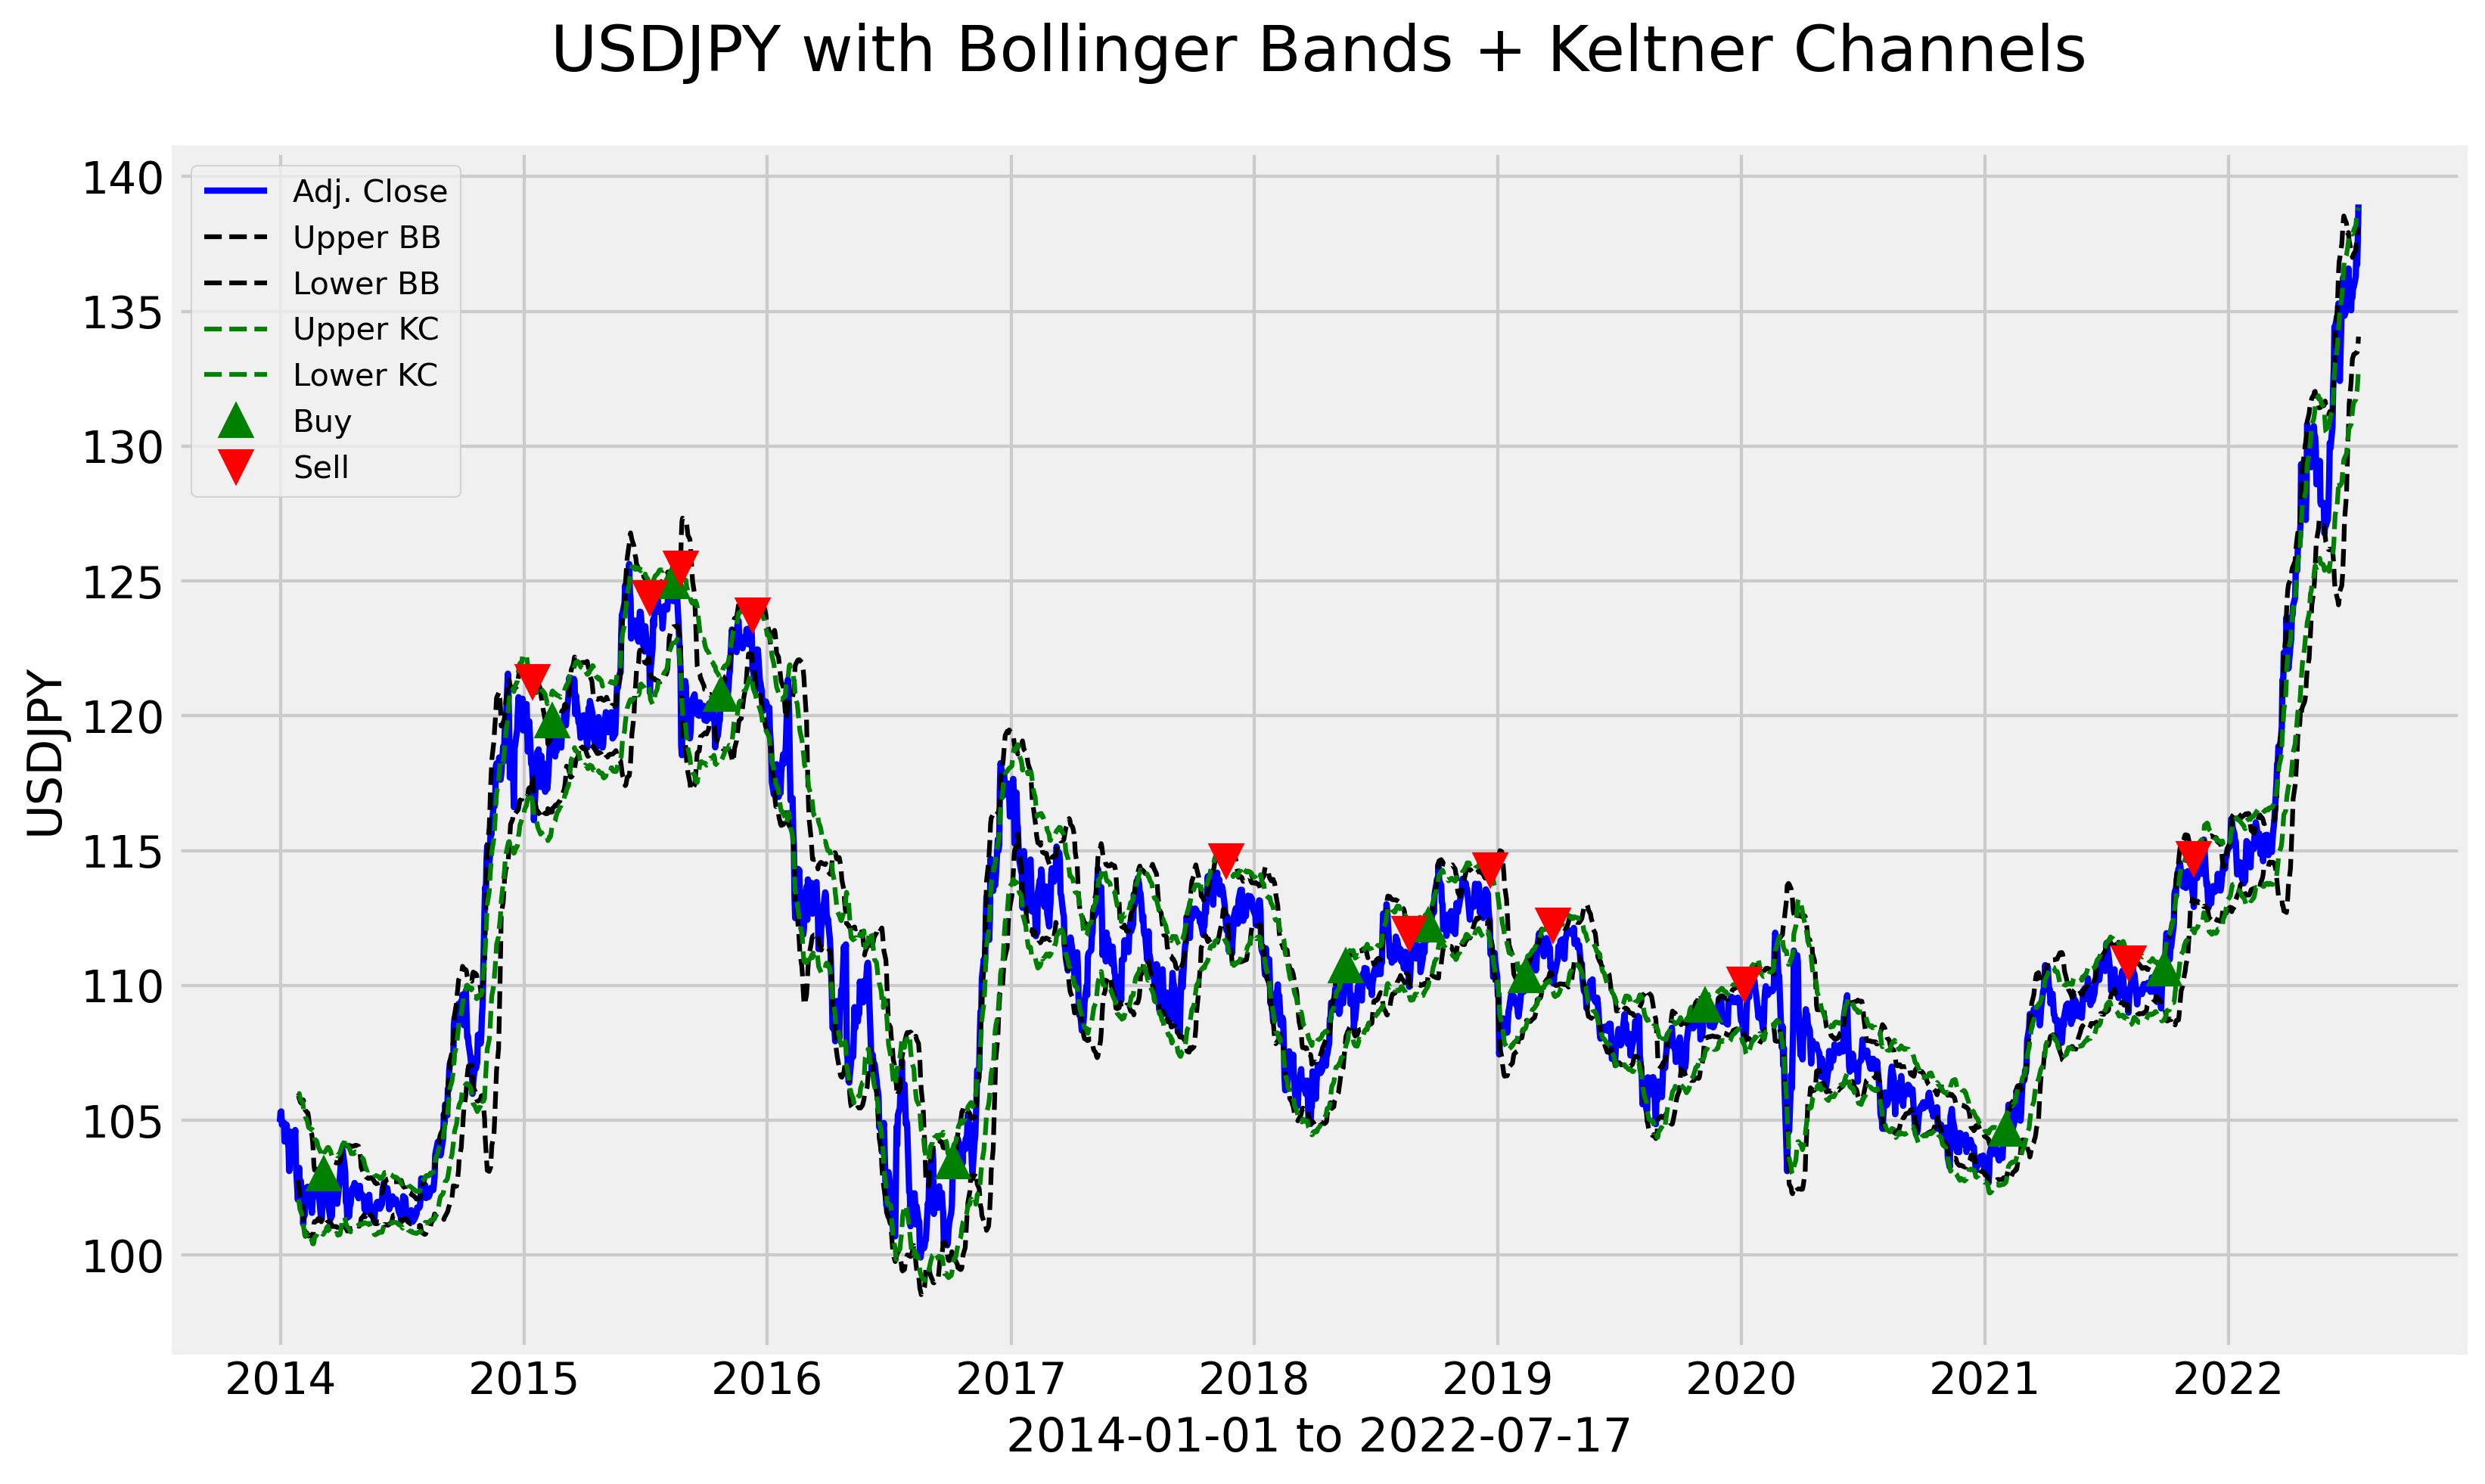

In [12]:
plot("USDJPY", USDJPY_signals)

In [13]:
def profit(data):
    
    """
    Calculate profit made from the momentum strategy.
    --------------
    Parameters
    
    data - pd.DataFrame
        DataFrame containing details of a stock's adjusted close price.
    --------------
    Returns total profit (all trades) and the probability of making a profit per trade.
    
    """
    
    data = data.copy()
        
    buy_prices = np.array(data.loc[data["Buy"] == 1, ["Adj Close"]])
    sell_prices = np.array(data.loc[data["Sell"] == 1, ["Adj Close"]])
    #profits = sell_prices - buy_prices
    #total_profit = profits.sum()
    total_profit = np.sum(sell_prices) - np.sum(buy_prices)
    #win_rate = len(profits[profits > 0]) / len(profits)
    
    #return f"Profit: {round(total_profit, 2)}", f"Win rate: {round(win_rate, 2)}"
    return f"Profit: {round(total_profit, 2)}"

In [14]:
#profit(USDJPY_combined_data)